# World Temperature

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from math import *

## Parseo de datos

In [9]:
infoWorldTemp = pd.read_csv('data/worldTemperature.csv', names = ['Año + Temp'])

ayt = infoWorldTemp['Año + Temp']

#Voy a parsear bien el csv que me aparece todo en una columna porque no tiene comas
fechas = []
temp = []
for strMal in ayt:
    strBien = strMal.split(' ')
    fechas.append(float(strBien[0]))
    temp.append(float(strBien[1]))

#SOBRE np.vstack
#El .T los pone uno al lado del otro en la matriz
#En la posicion 0 estan los valores w1...wn de la funcion, 
#el resto son en orden: resudio, rango de A, val singulares de A

## f(x) = w1\*x + w2\*1

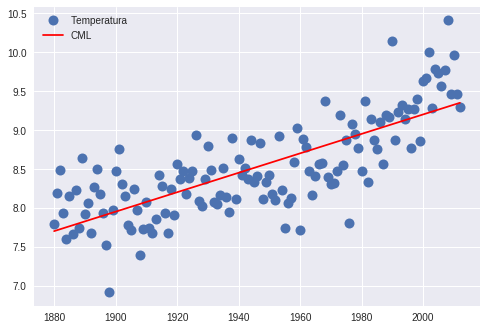

In [10]:
A = np.vstack([fechas, np.ones(len(fechas))]).T
w = np.linalg.lstsq(A, temp)[0]

##Este vendria a ser el Y de CML
funcionCML = [f*w[0] + w[1] for f in fechas]

plt.plot(fechas, temp, 'o', label='Temperatura', markersize=10)
plt.plot(fechas, funcionCML, 'r', label='CML')
plt.legend()
plt.show()

## f(x) = w1\*x^2 + w2\*x + w3\*1

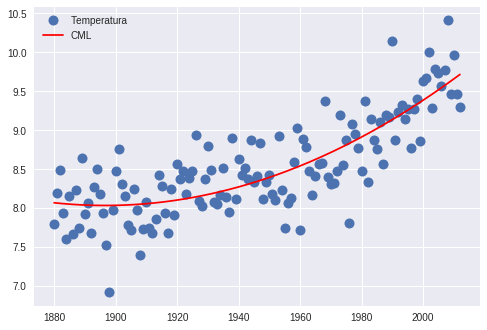

In [45]:
fechas2 = [f**2 for f in fechas]

A = np.vstack([fechas2, fechas, np.ones(len(fechas))]).T 
w = np.linalg.lstsq(A, temp)[0]

##Este vendria a ser el Y de CML
funcionCML = [w[0]*fechas2[i] + w[1]*fechas[i] + w[2] for i in range(len(fechas))]

plt.plot(fechas, temp, 'o', label='Temperatura', markersize=10)
plt.plot(fechas, funcionCML, 'r', label='CML')
plt.legend()
plt.show()

## f(x) con grado harcodeado

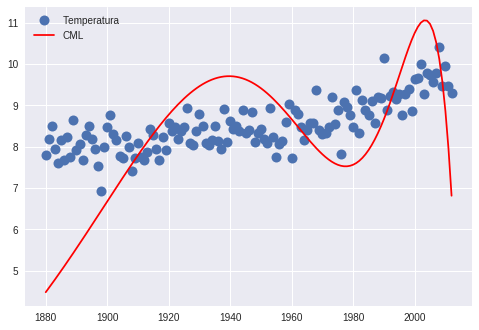

In [64]:
grado = 93
funciones = []
for i in range(grado,-1,-1):
    a = [f**i for f in fechas]
    funciones.append(a)

A = np.vstack([f for f in funciones]).T
w = np.linalg.lstsq(A, temp)[0]

##Este vendria a ser el Y de CML
funcionCML = []
for i in range(len(fechas)):
    val = 0
    for j in range(len(funciones)):
        val = val + w[j]*funciones[j][i]
    funcionCML.append(val)

plt.plot(fechas, temp, 'o', label='Temperatura', markersize=10)
plt.plot(fechas, funcionCML, 'r', label='CML')
plt.legend()
plt.show()

## f(x,y) = w1\*x^gradoX + w2\*y^gradoY + w3\*1

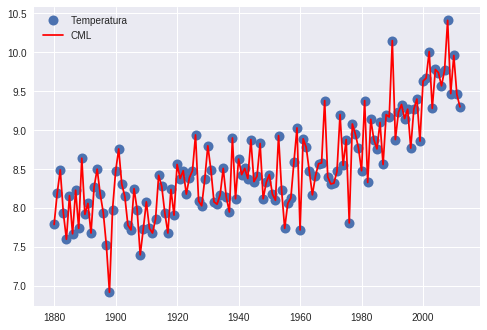

In [44]:
gradoX = 1
gradoY = 1

x = [f**gradoX for f in fechas]
y = [t**gradoY for t in temp]

A = np.vstack([x, y ,np.ones(len(fechas))]).T 
w = np.linalg.lstsq(A, temp)[0]

##Este vendria a ser el Y de CML
funcionCML = [w[0]*x[i] + w[1]*y[i] + w[2] for i in range(len(fechas))]

plt.plot(fechas, temp, 'o', label='Temperatura', markersize=10)
plt.plot(fechas, funcionCML, 'r', label='CML')
plt.legend()
plt.show()

## Probando funciones en general

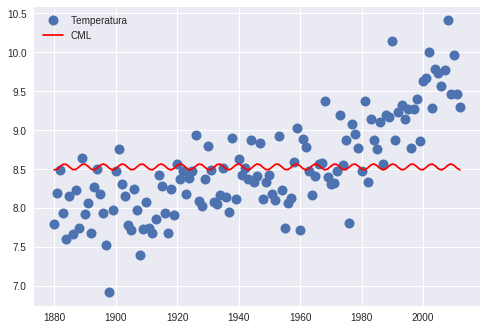

In [81]:
funciones = []
funciones.append([sin(f) for f in fechas])
funciones.append(np.ones(len(fechas)))
#funciones.append([cos(f)**9 for f in fechas])
#funciones.append([f**3 for f in fechas])

A = np.vstack([f for f in funciones]).T 
w = np.linalg.lstsq(A, temp)[0]

##Este vendria a ser el Y de CML
funcionCML = []
for i in range(len(fechas)):
    val = 0
    for j in range(len(funciones)):
        val = val + w[j]*funciones[j][i]
    funcionCML.append(val)

plt.plot(fechas, temp, 'o', label='Temperatura', markersize=10)
plt.plot(fechas, funcionCML, 'r', label='CML')
plt.legend()
plt.show()